In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from get_image_dataset import get_dataloader, get_label
from PIL import Image
from torchvision import transforms as T
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
train, test = get_dataloader('normalized_red_quantized', patch_size=12, batch_size=50)

130585
104468
26117
2924
523


In [4]:
len(train)

116936

In [3]:
class ClusteringLayer(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.n_classes = n_classes 
        self.alpha = 1.0
        self.weights = nn.Parameter(torch.randn((self.n_classes, self.n_classes)))
    def forward(self,x):
        assert x.shape[1] == self.n_classes
        q = 1.0 / (1.0 + torch.sqrt(torch.sum(torch.square(torch.unsqueeze(x, 1) - self.weights), dim=2)) ** 2 / self.alpha)
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = torch.transpose(torch.transpose(q,0,1)/torch.sum(q,dim=1),0,1)
        return q

In [ ]:
def test_paper_grad():
    z = torch.randn((4,5), requires_grad=True)
    u = torch.randn((5,5), requires_grad=True)
    target = nn.functional.softmax(nn.functional.one_hot(torch.tensor(1), num_classes=5).to(torch.float32))
    target = target.repeat(4,1)
    def get_q(z,u):
        q = 1.0 / (1.0 + torch.sqrt(torch.sum(torch.square(torch.unsqueeze(z, 1) - u), dim=2)) ** 2 / 1)
        q = q ** ((1 + 1.0) / 2.0)
        q = torch.transpose(torch.transpose(q,0,1)/torch.sum(q,dim=1),0,1)
        return q
    q = get_q(z,u)
    def z_grad(z,u,target, q):
        samples = z.shape[0]
        embedding_length = z.shape[1]
        gradient = torch.zeros(samples, embedding_length)
        for i in range(samples):
            sum = 0
            for j in range(u.shape[0]):
                sum += 1.0 / (1.0 + torch.norm(z[i] - u[j], 2) ** 2)
            gradient[i] = 2 * sum * (target[0][j] - q[i][j]) * (z[i] - u[j])
        return gradient
    def u_grad(z,u,target,q):
        return -z_grad(z,u,target,q)
    z.retain_grad()
    print(f'q: {q}')
    print(f'z: {z}')
    print(f'u: {u}')
    z1 = z.detach().clone()
    z2 = z.detach().clone()
    z_g = z_grad(z,u,target,q)
    print(f'My z gradient: {z_g}')
    loss_func = nn.KLDivLoss()
    print(f"Pytorch Gradient of q w.r.t z: {z.grad}") 
    
    print(f'KL Loss before using my gradient: {loss_func(nn.functional.log_softmax(q, dim=1), target)}')
    for _ in range(10):
        with torch.no_grad():
            z_g = z_grad(z1,u,target,q)
            z1 -= z_g
    q1 = get_q(z1,u)
    print(f'KL Loss after using my gradient:  {loss_func(nn.functional.log_softmax(q1, dim=1), target)}')
    print(f'KL Loss before using pytorch gradient: {loss_func(nn.functional.log_softmax(q, dim=1), target)}')
    for _ in range(10):
        with torch.no_grad():
            q = get_q(z2,u)
            loss = loss_func(nn.functional.log_softmax(q, dim=1), target)
            loss.backward()
            z2 -= z2.grad
    q2 = get_q(z2,u)
    print(f'KL Loss after using pytorch gradient:  {loss_func(nn.functional.log_softmax(q2, dim=1), target)}')
test_paper_grad()

In [4]:
class SSLDEC(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
        self.size = (32,64,128)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,self.size[0],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[0],self.size[0],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[0],self.size[0],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
            )
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.size[0],self.size[1],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[1],self.size[1],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[1],self.size[1],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.size[1],self.size[2],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[2],self.size[1],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(self.size[1],self.size[0],(3,3), 1, 'same'),
            nn.ELU(),
            nn.Dropout2d(p=0.25)
        )
        self.dense = nn.Sequential(
            nn.Linear(288, self.size[1]),
            nn.ELU(),
            nn.Linear(self.size[1],6),
            nn.ELU()
        )
        self.clustering = ClusteringLayer(6)
        self.to(self.device)
    def forward(self, x):
        x = self.conv3(self.pool(self.conv2(self.pool(self.conv1(x)))))
        x = torch.flatten(x, 1)
        x = self.dense(x)
        x = self.clustering(x)
        x = nn.functional.log_softmax(x,dim=1)
        return x

In [5]:
dummy = SSLDEC()
dummy(torch.randn((2,3,12,12)).to(dummy.device))

torch.Size([2, 6])


tensor([[-1.7161, -1.8730, -1.7712, -1.7753, -1.8194, -1.8026],
        [-1.7154, -1.8729, -1.7722, -1.7763, -1.8178, -1.8029]],
       device='mps:0', grad_fn=<LogSoftmaxBackward0>)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        epoch_losses = []
        for batch in dataloader:
            # batch should contain single image and mask
            img_patch, label_dist = batch
            label_dist = label_dist.to(model.device)
            outputs = model(img_patch.to(model.device))
            loss = criterion(outputs, label_dist)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # if epoch > 10:
            epoch_losses.append(loss.item())
            clear_output(wait=True)
            plt.plot(epoch_losses, label='Epoch Loss')
            plt.xlabel('Batch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.title("Epoch Loss Over Batches")
            plt.show()

        running_loss /= len(dataloader)
        train_losses.append(running_loss)

        # show graph of loss
        # clear_output(wait=True)
        # plt.plot(train_losses, label='Training Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.grid(True)
        # plt.title("Training Loss Over Epochs")
        # plt.show()
    

In [ ]:
nn.functional.softmax(nn.functional.one_hot(torch.tensor(1), num_classes=6).to(torch.float32))

In [6]:
len(test)

523

In [6]:
model = SSLDEC()
loss_func = nn.KLDivLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 2*(10**-5))

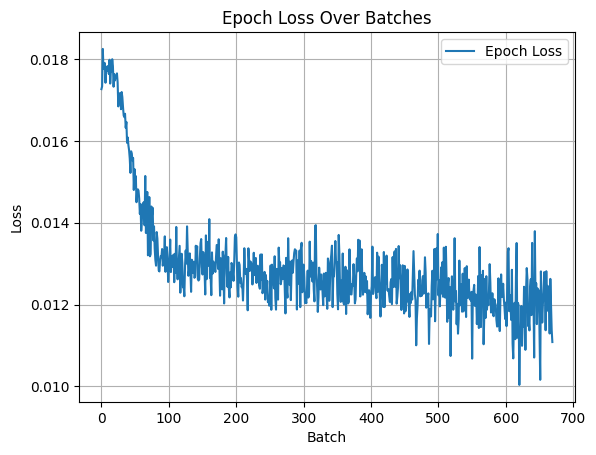

  0%|          | 0/5 [05:36<?, ?it/s]


KeyboardInterrupt: 

In [7]:
train_model(model, train, loss_func, optimizer, num_epochs=5)

In [8]:
def evaluate_model(model, testloader):
    model.eval()
    count = 0.0
    total = 0.0
    for batch in testloader:
        img_patch, label_dist = batch
        label_dist = label_dist.to(model.device)
        preds = model(img_patch.to(model.device))
        label_tensor = torch.argmax(label_dist, dim=1)
        for i in range(len(preds)):
            pred = torch.argmax(preds[i])
            if pred == label_tensor[i]:
                count += 1
            total += 1
    print(f'Accuracy: {count / total} of {total} patches')

In [9]:
evaluate_model(model, test)

Accuracy: 0.4534977217904047 of 26117.0 patches


In [11]:
torch.argmax(torch.randn((50,6)), dim=1).shape

torch.Size([50])

/Users/jackylei/Documents/Semiconductors/Playground/get_image_dataset.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  label_dist = nn.functional.softmax(nn.functional.one_hot(label_tensor, num_classes=6).to(torch.float32))


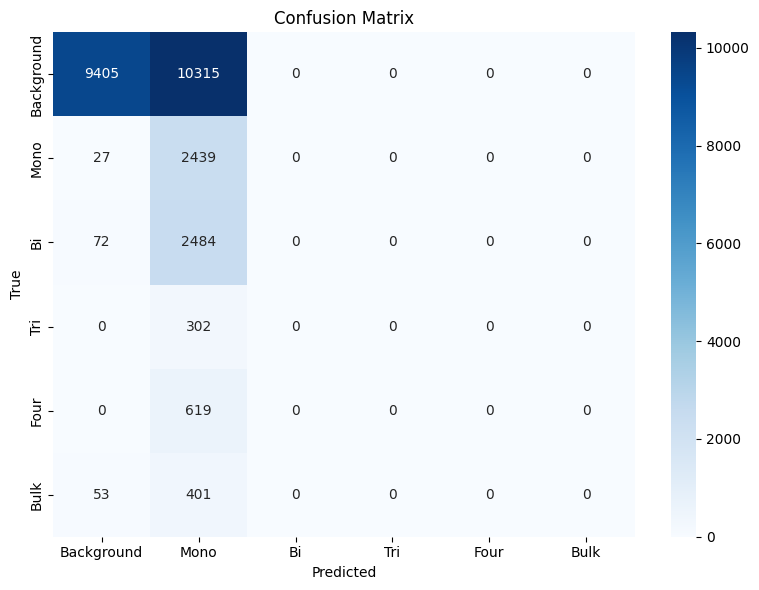

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, dataloader, class_names, device='cpu', normalize=False):
    """
    Computes and plots the confusion matrix for a classification model.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader with (inputs, labels).
        class_names: List of class names.
        device: 'cpu' or 'cuda'.
        normalize: If True, show percentages instead of raw counts.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            img_patch, label = batch
            label = label.to(model.device)
            img_patch = img_patch.to(model.device).to(torch.float32)
            outputs = model(img_patch)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            target = torch.argmax(label, dim=1).cpu().numpy()
            all_preds.append(pred)
            all_labels.append(target)

    preds = np.hstack(all_preds)
    labels = np.hstack(all_labels)

    cm = confusion_matrix(labels, preds)
    
    if normalize:
        cm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, test, class_names=['Background', 'Mono', 'Bi', "Tri", "Four", "Bulk"])

In [15]:
len(train)

116936

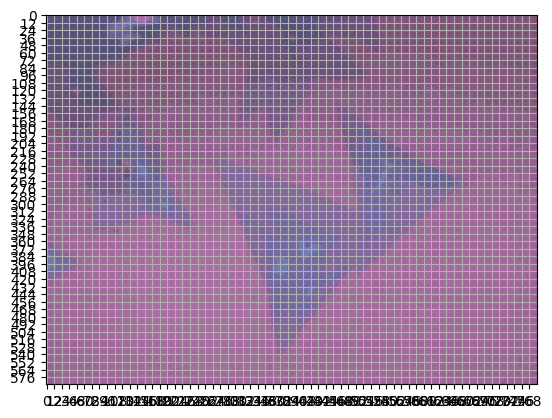

In [ ]:
def patch_image(file_path, patch_size):
    width, height = patch_size
    img = Image.open(file_path)
    plt.imshow(img)
    plt.xticks([i for i in range(0,img.size[0], width)])
    plt.yticks([i for i in range(0,img.size[1], height)])
    plt.grid()
    plt.show()
patch_image('../Image Segmentation Data/denoised_quantized/4_MoS2_4.jpg',(12,12))